In [1]:
import os
import tensorflow as tf
import keras 
import keras.layers as layers
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-09-28 01:10:33.609364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 01:10:33.621393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 01:10:33.624941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 01:10:33.633220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-28 01:10:34.244535: W tensorflow/compiler/tf2

In [2]:
# List available devices
physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))

if physical_devices:
    try:
        # Restrict TensorFlow to only allocate a small amount of memory on the GPU
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow is using GPU")
    except RuntimeError as e:
        print(e)
else:
    print("TensorFlow is not using GPU")


GPUs Available:  1
TensorFlow is using GPU


I0000 00:00:1727467835.799707   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727467835.819556   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727467835.819603   14634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

train_dir = os.path.join(parent_dir, current_dir, 'data', 'processed', 'train')
test_dir = os.path.join(parent_dir, current_dir, 'data', 'processed', 'test')
img_size = (64, 128, 1)


In [4]:
train_ds = keras.utils.image_dataset_from_directory(
  train_dir, 
  labels='inferred',
  color_mode='grayscale',
  image_size=(img_size[0], img_size[1]),
)
valid_ds = keras.utils.image_dataset_from_directory(
  test_dir, 
  labels='inferred',
  color_mode='grayscale',
  image_size=(img_size[0], img_size[1]),
)
num_classes = len(train_ds.class_names)
target_names = valid_ds.class_names

# for image_batch, labels_batch in valid_ds:
#   for i in range(len(image_batch)):
#     plt.imshow(image_batch[i].numpy().astype("uint8")[:, :, 0], cmap='gray')
#     plt.title(f"Label: {labels_batch[i].numpy()}")
#     plt.show()

# for image_batch, labels_batch in train_ds:
#   for i in range(len(image_batch)):
#       plt.imshow(image_batch[i].numpy().astype("uint8")[:, :, 0], cmap='gray')
#       plt.title(f"Label: {labels_batch[i].numpy()}")
#       plt.show()


NotFoundError: Could not find directory /mnt/c/Studies/University/Seventh Sem/Gen AI/Assignment/A1/Q1/data/processed/train

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [64]:
data_augmentation = keras.Sequential(
  [
    # layers.RandomFlip("horizontal", input_shape=img_size),
    layers.RandomRotation(0.1, input_shape=img_size),
    layers.RandomZoom(0.1),
    layers.Lambda(lambda x: 1 - x) 

  ]
)

model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes,activation='softmax', name="outputs")
])


In [65]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_17 (Sequential)      │ (None, 64, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 64, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 128, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 32, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 16, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 8, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 16, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 4, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 184)            │        23,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,744 (1.32 MB)

 Trainable params: 346,488 (1.32 MB)

 Non-trainable params: 256 (1.00 KB)

In [67]:
early_stopping = keras.callbacks.EarlyStopping(
  patience=10,
  min_delta=0.001,
  restore_best_weights=True,
)

epochs = 50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.0000e+00 - loss: 5.2719

2024-09-28 01:07:17.328579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_18_1/dropout_7_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0078 - loss: 5.3340 - val_accuracy: 0.0054 - val_loss: 5.2138
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0023 - loss: 5.2894 - val_accuracy: 0.0054 - val_loss: 5.2067
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0264 - loss: 5.0944 - val_accuracy: 0.0054 - val_loss: 5.1660
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0626 - loss: 4.8618 - val_accuracy: 0.0109 - val_loss: 5.0691
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0632 - loss: 4.6655 - val_accuracy: 0.0163 - val_loss: 4.9783
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0837 - loss: 4.4934 - val_accuracy: 0.0272 - val_loss: 4.8739
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1257 - loss: 4.3518 - val_accuracy: 0.0163 - val_loss: 4.7751
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1211 - loss: 4.1794 - val_accuracy: 0.0217 - val_loss: 4.

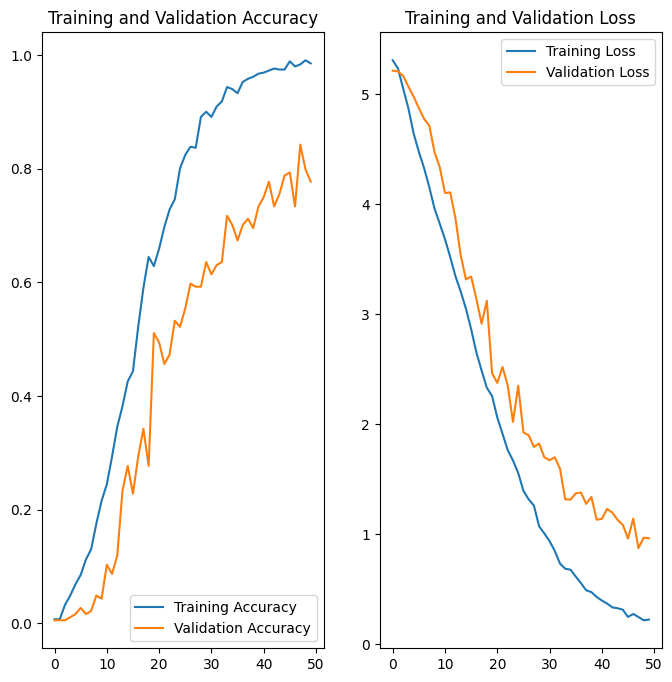

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Ensure epochs_range matches the length of acc and val_acc

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
import numpy as np

# Get predictions on the validation set
y_pred_prob = model.predict(valid_ds)  # Predict class probabilities
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert probabilities to class labels

y_true = []
for images, labels in valid_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)  # Convert the list to a numpy array


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [70]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report for precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

# Accuracy score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
         100       1.00      1.00      1.00         1
         101       0.00      0.00      0.00         1
         102       0.00      0.00      0.00         1
         103       1.00      1.00      1.00         1
         104       1.00      1.00      1.00         1
         105       0.00      0.00      0.00         1
         106       0.50      1.00      0.67         1
         107       0.00      0.00      0.00         1
         108       1.00      1.00      1.00         1
         109       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
         110       1.00      1.00      1.00         1
         111       1.00      1.00      1.00         1
         112       0.00      0.00      0.00         1
         113       0.50      1.00      0.67         1
         114       1.00    

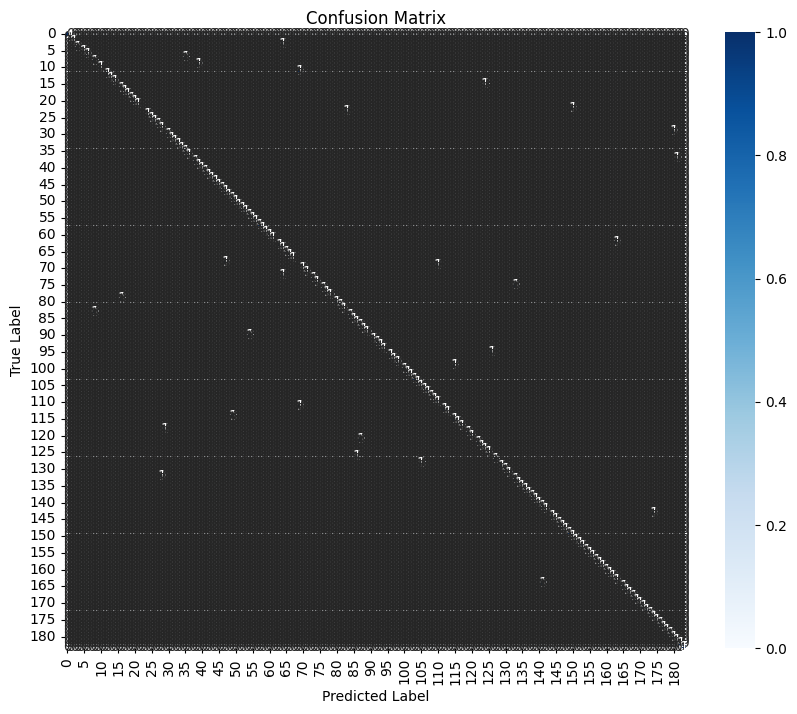

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
base_model = tf.keras.applications.ResNet50(input_shape=(img_size[0], img_size[1], 3),include_top=False,weights='imagenet')

base_model.trainable = False  # Freeze the base model layers
model = keras.Sequential([
    layers.InputLayer(input_shape=(img_size[0], img_size[1], 1)),  # Original input shape
    layers.Conv2D(3, (3, 3), padding='same', activation='relu'),  # Convert grayscale to RGB
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Replace num_classes with the actual number of classes
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 128, 3)     │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 184)            │        23,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,873,750 (91.07 MB)

 Trainable params: 286,038 (1.09 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/15


I0000 00:00:1727466944.518986    1404 service.cc:146] XLA service 0x7ff1480018d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727466944.519015    1404 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-09-28 00:55:44.716390: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-28 00:55:46.384130: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5766', 168 bytes spill stores, 452 bytes spill loads

2024-09-28 00:55:48.281468: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8800', 36 bytes spill stores, 40 bytes spill loads

2024-09-28 00:55:48.358651: I external/loca

 5/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0061 - loss: 5.6324    

I0000 00:00:1727466954.214716    1404 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.0147 - loss: 5.4701

2024-09-28 00:56:04.760885: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1708', 176 bytes spill stores, 176 bytes spill loads

2024-09-28 00:56:04.817919: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1708', 12 bytes spill stores, 12 bytes spill loads



18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 783ms/step - accuracy: 0.0150 - loss: 5.4555 - val_accuracy: 0.0326 - val_loss: 4.9746
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0979 - loss: 4.7625 - val_accuracy: 0.0870 - val_loss: 4.4818
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1918 - loss: 4.1566 - val_accuracy: 0.2011 - val_loss: 3.8340
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3660 - loss: 3.2410 - val_accuracy: 0.3587 - val_loss: 3.2176
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6049 - loss: 2.5020 - val_accuracy: 0.4783 - val_loss: 2.6649
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7689 - loss: 1.6283 - val_accuracy: 0.5652 - val_loss: 2.2504
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8704 - loss: 1.2345 - val_accuracy: 0.6033 - val_loss: 1.9584
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9180 - loss: 0.8975 - val_accuracy: 0.6359 - val_loss: 

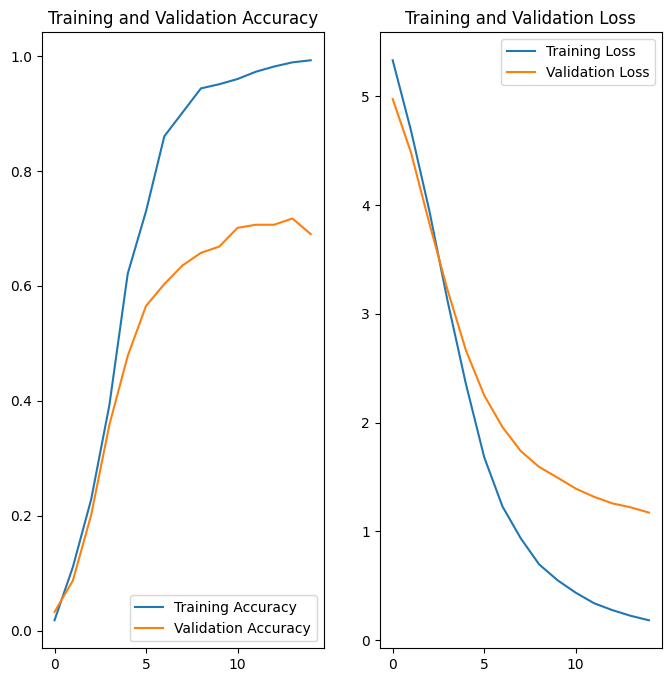

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
import numpy as np

# Get predictions on the validation set
y_pred_prob = model.predict(valid_ds)  # Predict class probabilities
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert probabilities to class labels

y_true = []
for images, labels in valid_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)  # Convert the list to a numpy array


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step


2024-09-28 00:56:20.299666: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


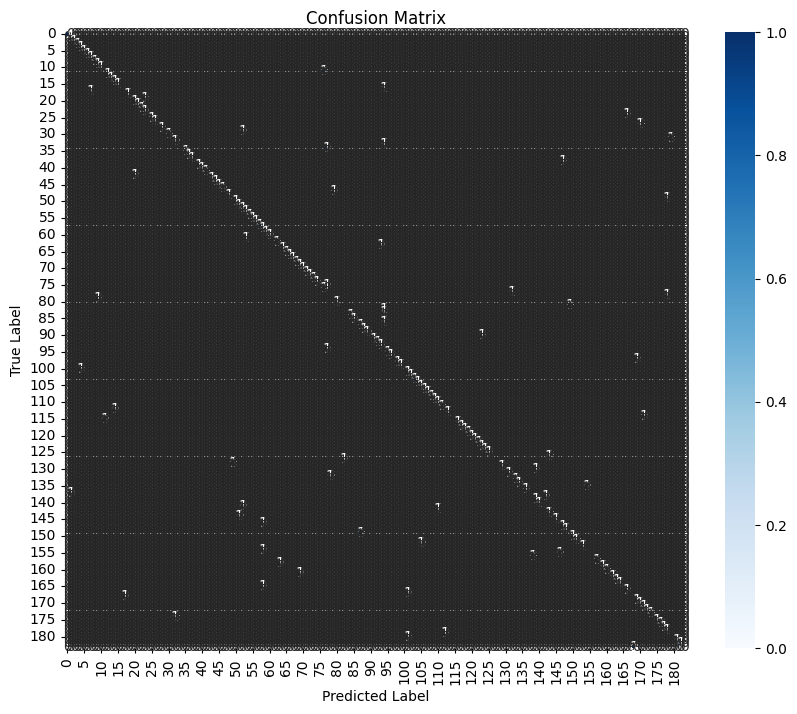

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()